In [10]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import pymongo
from hdfs import InsecureClient
import pyarrow as pa
import pyarrow.parquet as pq
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import pyspark
import sys
import findspark
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext, RDD
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import mean, sum, count, col,substring


import collections
collections.Iterable = collections.abc.Iterable
collections.Sequence = collections.abc.Sequence
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [11]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

In [12]:
hdfs_host = 'http://10.4.41.47:9870'
hdfs_client = InsecureClient(hdfs_host, user='bdm')

### Exploitation Zone

In [13]:
exploitation_path='./ExploitationZone'

connectionExploitation = create_connection(exploitation_path)
curExploitation = connectionExploitation.cursor()

Connection to SQLite DB successful


In [14]:
config = {
        "spark.cores.max": "5",
        "spark.master": "local[*]",
        "spark.python.profile": "false",
        "spark.ui.enabled": "false",
        "spark.executor.extraClassPath": "./sqlite-jdbc-3.34.0.jar",
        "spark.driver.extraClassPath": "./sqlite-jdbc-3.34.0.jar",
        "spark.jars": "./sqlite-jdbc-3.34.0.jar"
    }
conf = SparkConf()
for key, value in config.items():
    conf = conf.set(key, value)
sc = SparkContext(appName="test", conf=conf)

sqlcontext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=test, master=local[*]) created by __init__ at C:\Users\Gerard\AppData\Local\Temp\ipykernel_9904\866062475.py:13 

In [15]:
table_markets = 'table_markets'
table_income = 'table_income'
table_idealista = 'table_idealista' 

In [91]:
MV1 = sqlcontext.read.parquet(f'hdfs://pidgey.fib.upc.es:27000/user/bdm/FormattedZone/{table_idealista}.parquet')
price_column = 'price'
rooms_column = 'rooms'
bath_column = 'bathrooms'
pa_column = 'priceByArea'
group_column1 = 'neighborhood_id'
substring_col = 'timestamp'
district = 'district'
size_col = 'size'
result1 = MV1.groupBy(group_column1,col(substring_col).substr(1, 4).alias('Year'),district).agg(mean(price_column).alias('price'),
                mean(rooms_column).alias('rooms'),
                mean(bath_column).alias('bathrooms'),
                count(rooms_column).alias('count'),
                mean(pa_column).alias('pba'),
                sum(rooms_column).alias('totalrooms'),
                sum(bath_column).alias('totalbathrooms'),
                mean(size_col).alias('mean_size'))


In [66]:
MV2 = sqlcontext.read.parquet(f'hdfs://pidgey.fib.upc.es:27000/user/bdm/FormattedZone/{table_markets}.parquet')
count_column = 'register_id'
group_column1 = 'neighborhood_id'
district_column = 'district'
result2 = MV2.groupBy(group_column1,district_column).agg(count(count_column).alias('numMarkets'))


In [18]:
MV3 = sqlcontext.read.parquet(f'hdfs://pidgey.fib.upc.es:27000/user/bdm/FormattedZone/{table_income}.parquet')
avg_column = 'index_rfd'
group_column1 = 'neighborhood_id'
substring_col = 'timestamp'
result3 = MV3.groupBy(group_column1,col(substring_col).substr(1, 4).alias('Year')).agg(mean(avg_column).alias('average'))


In [92]:
result1.toPandas().to_sql(con=connectionExploitation,name='mvidealista',if_exists='append',index=['neighborhood_id,year'])
result2.toPandas().to_sql(con=connectionExploitation,name='mvmarkets',if_exists='append',index=['neighborhood_id_ind'])
result3.toPandas().to_sql(con=connectionExploitation,name='mvincome',if_exists='append',index=['neighborhood_id_ind'])

7855

### Dashboard
#### Data retrieval for Dashboard

In [68]:
query = 'SELECT m.district, m.numMarkets,  avg(i.average) FROM mvmarkets m inner join mvincome i on i.neighborhood_id = m.neighborhood_id GROUP BY m.neighborhood_id'
res1 = connectionExploitation.execute(query)
dataPlot1 = res1.fetchall()

In [59]:
query = 'SELECT (m.rooms+m.bathrooms) , m.pba as rph, m.district FROM mvidealista m'
res2 = connectionExploitation.execute(query)
dataPlot2 = res2.fetchall()

In [78]:
query = 'SELECT AVG(m.price/(m.totalrooms+m.totalbathrooms)) as PricePerRoom, avg(m.pba), m.district FROM mvidealista m  GROUP BY m.district'
res3 = connectionExploitation.execute(query)
dataPlot3 = res3.fetchall()

In [93]:
query = 'SELECT avg(m.mean_size),m.district FROM mvidealista m  GROUP BY m.district'
res4 = connectionExploitation.execute(query)
dataPlot4 = res4.fetchall()

#### Plots

C:\Users\Gerard\AppData\Local\Temp\ipykernel_9904\4040374963.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plt1 = sns.barplot(x = [x[0]for x in dataPlot1],y=[x[1]for x in dataPlot1],ax=axs[0,0], palette="viridis",ci=None)
C:\Users\Gerard\AppData\Local\Temp\ipykernel_9904\4040374963.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plt4 = sns.barplot(x = [x[0]for x in dataPlot4],y=[x[1]for x in dataPlot4],ax=axs[1,1],ci=None)


[Text(0.5, 0, 'Size(m^2)'),
 Text(0, 0.5, 'District'),
 Text(0.5, 1.0, 'Size per district')]

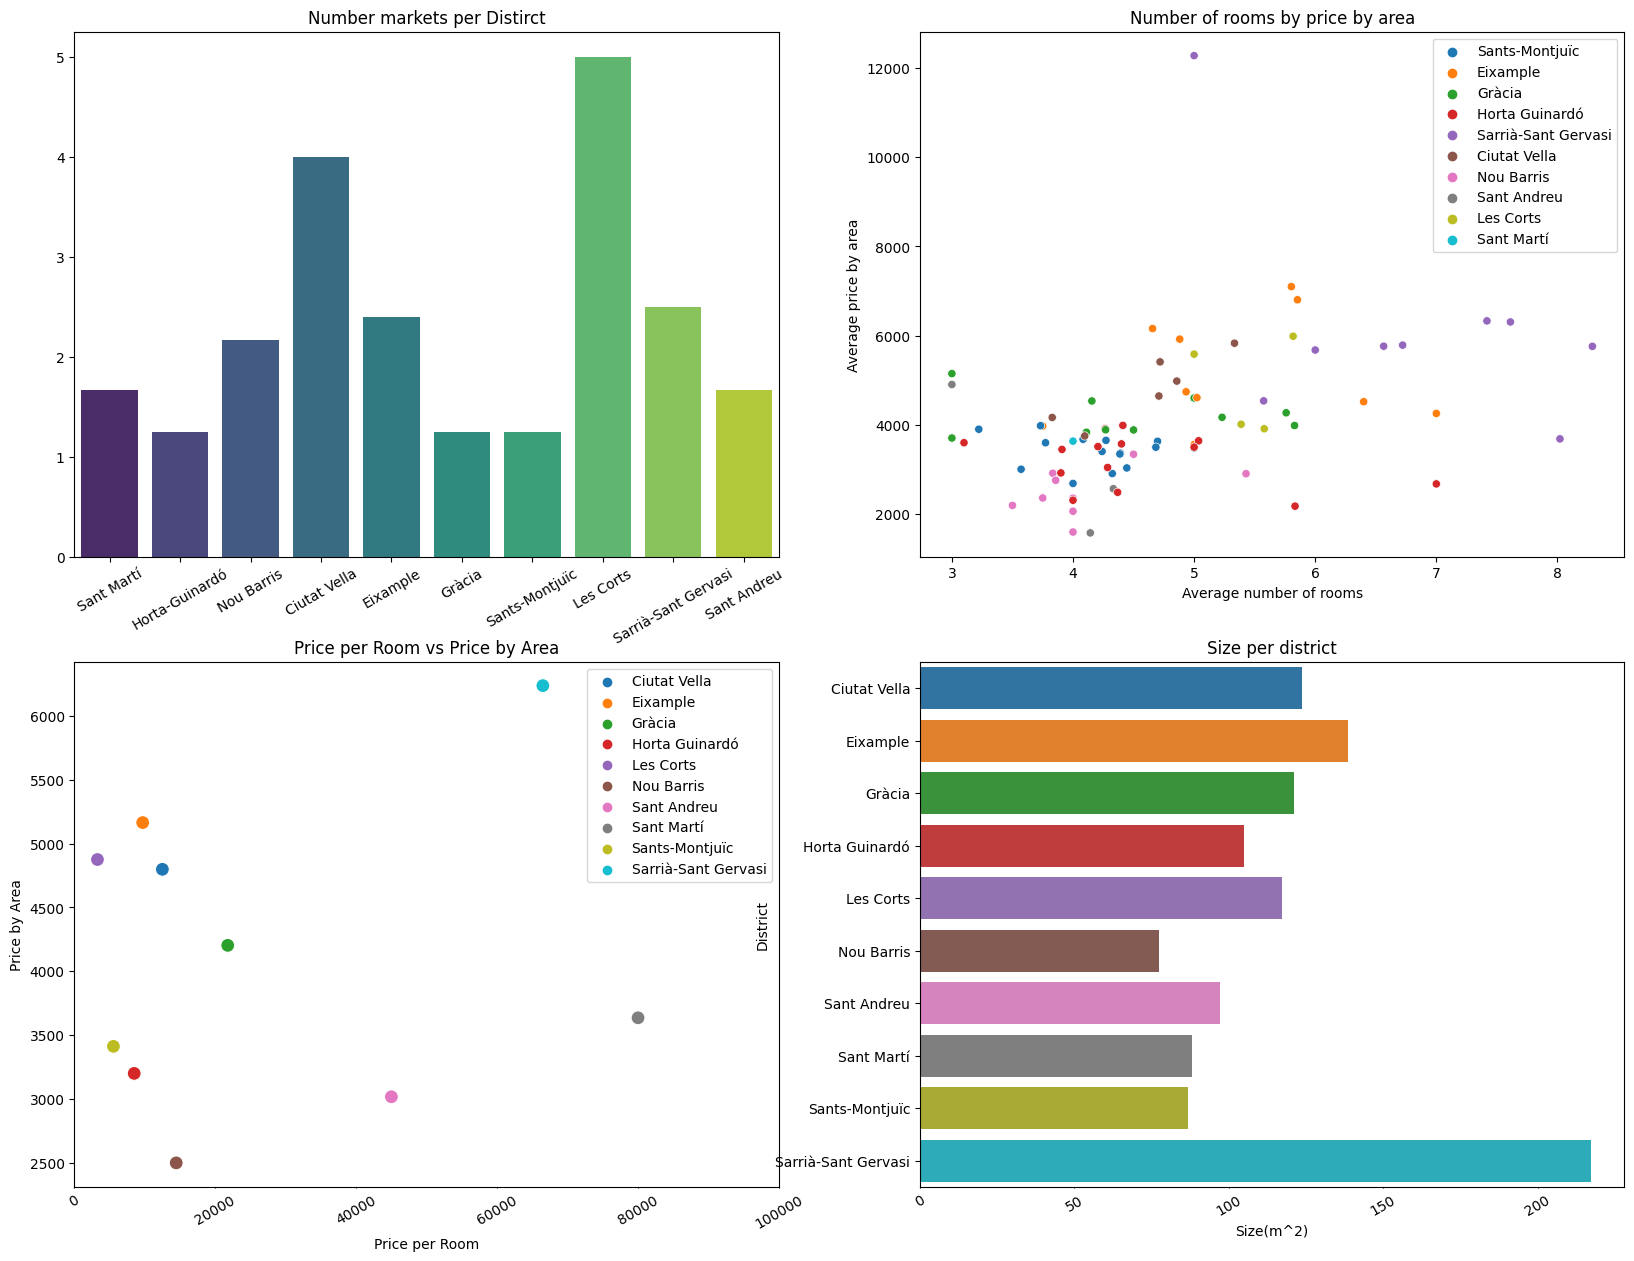

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))

plt1 = sns.barplot(x = [x[0]for x in dataPlot1],y=[x[1]for x in dataPlot1],ax=axs[0,0], palette="viridis",ci=None)
plt1.tick_params(axis ='x',rotation=30)
plt1.set(title="Number markets per Distirct")

plt2 = sns.scatterplot(x = [x[0]for x in dataPlot2],y=[x[1]for x in dataPlot2], hue=[x[2]for x in dataPlot2],ax=axs[0,1])
plt2.set(xlabel = "Average number of rooms", ylabel = "Average price by area", title= "Number of rooms by price by area")

plt3 = sns.scatterplot(x = [x[0]for x in dataPlot3],y=[x[1]for x in dataPlot3],hue=[x[2]for x in dataPlot3],s=100 ,ax=axs[1,0])
plt3.tick_params(axis ='x',rotation=30,size = 1)
plt3.set(xlabel='Price per Room', ylabel='Price by Area',xlim=(0,100000),title='Price per Room vs Price by Area')

plt4 = sns.barplot(x = [x[0]for x in dataPlot4],y=[x[1]for x in dataPlot4],ax=axs[1,1],ci=None)
plt4.tick_params(axis ='x',rotation=30,size = 1)
plt4.set(xlabel='Size(m^2)', ylabel='District',title='Size per district')
